### 1) Subimos los datasets de todos los años (2022, 2023 y 2024)

In [1]:
import os

# creamos la carpeta
os.makedirs("CO_Florida", exist_ok= True)

In [2]:
# subimos los archivos
from google.colab import files
# manualmente
uploaded = files.upload()
# a la carpeta
for filename in uploaded.keys():
  os.replace(filename, f"CO_Florida/{filename}")
  print(f"Archivo {filename} subido a CO_Florida")

Saving co_data_2022.csv to co_data_2022.csv
Saving co_data_2023.csv to co_data_2023.csv
Saving co_data_2024.csv to co_data_2024.csv
Archivo co_data_2022.csv subido a CO_Florida
Archivo co_data_2023.csv subido a CO_Florida
Archivo co_data_2024.csv subido a CO_Florida


### 2) Importamos las librerias y leemos los datos

In [3]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Leer archivos
df_2022 = pd.read_csv("CO_Florida/co_data_2022.csv")
df_2023 = pd.read_csv("CO_Florida/co_data_2023.csv")

# Limpiar nombres de columna (quitar espacios al inicio/final)
df_2022.columns = df_2022.columns.str.strip()
df_2023.columns = df_2023.columns.str.strip()

# Unir datasets
df = pd.concat([df_2022, df_2023], ignore_index=True)

# Ver las primeras filas para confirmar
print(df.head())

         Date Source    Site ID  POC  Daily Max 8-hour CO Concentration Units  \
0  01/01/2022    AQS  120110034    1                                0.4   ppm   
1  01/02/2022    AQS  120110034    1                                0.3   ppm   
2  01/03/2022    AQS  120110034    1                                0.2   ppm   
3  01/04/2022    AQS  120110034    1                                0.2   ppm   
4  01/05/2022    AQS  120110034    1                                0.2   ppm   

   Daily AQI Value     Local Site Name  Daily Obs Count  Percent Complete  \
0                5  Daniela Banu NCORE               19              79.0   
1                3  Daniela Banu NCORE               24             100.0   
2                2  Daniela Banu NCORE               24             100.0   
3                2  Daniela Banu NCORE               24             100.0   
4                2  Daniela Banu NCORE               18              75.0   

   ...  AQS Parameter Description Method Code  CBS

### 3) Limpiamos los datos

In [4]:
# Filtrar columnas importantes y renombrar
df = df[['Date', 'Daily Max 8-hour CO Concentration']]
df.rename(columns={'Daily Max 8-hour CO Concentration': 'CO'}, inplace=True)

# Convertir fechas y crear columnas de año y mes
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Mostrar primeras filas
print(df.head())


        Date   CO  Year  Month
0 2022-01-01  0.4  2022      1
1 2022-01-02  0.3  2022      1
2 2022-01-03  0.2  2022      1
3 2022-01-04  0.2  2022      1
4 2022-01-05  0.2  2022      1


### 4) Calculamos el promedio mensual

In [5]:
# Agrupar por año y mes para calcular promedio mensual
monthly_avg = df.groupby(["Year", "Month"])["CO"].mean().reset_index()

print("Promedios mensuales de CO (2022 y 2023):")
print(monthly_avg)

Promedios mensuales de CO (2022 y 2023):
    Year  Month        CO
0   2022      1  0.360924
1   2022      2  0.366071
2   2022      3  0.348780
3   2022      4  0.293304
4   2022      5  0.327437
5   2022      6  0.332389
6   2022      7  0.259470
7   2022      8  0.320513
8   2022      9  0.350000
9   2022     10  0.378986
10  2022     11  0.317761
11  2022     12  0.348462
12  2023      1  0.432129
13  2023      2  0.380000
14  2023      3  0.360256
15  2023      4  0.347287
16  2023      5  0.368165
17  2023      6  0.391915
18  2023      7  0.368016
19  2023      8  0.358929
20  2023      9  0.367841
21  2023     10  0.341810
22  2023     11  0.333712
23  2023     12  0.361753


### 5) Crear variables adicionales para el modelo

In [6]:
# Crear columnas de lags (CO del mes anterior y dos meses antes)
monthly_avg['CO_lag1'] = monthly_avg['CO'].shift(1)
monthly_avg['CO_lag2'] = monthly_avg['CO'].shift(2)

# Crear variables dummies para los meses
month_dummies = pd.get_dummies(monthly_avg['Month'], prefix='Month')
monthly_avg = pd.concat([monthly_avg, month_dummies], axis=1)

# Eliminar filas con NaN generadas por los lags
monthly_avg.dropna(inplace=True)

print(monthly_avg.head())


   Year  Month        CO   CO_lag1   CO_lag2  Month_1  Month_2  Month_3  \
2  2022      3  0.348780  0.366071  0.360924    False    False     True   
3  2022      4  0.293304  0.348780  0.366071    False    False    False   
4  2022      5  0.327437  0.293304  0.348780    False    False    False   
5  2022      6  0.332389  0.327437  0.293304    False    False    False   
6  2022      7  0.259470  0.332389  0.327437    False    False    False   

   Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
2    False    False    False    False    False    False     False     False   
3     True    False    False    False    False    False     False     False   
4    False     True    False    False    False    False     False     False   
5    False    False     True    False    False    False     False     False   
6    False    False    False     True    False    False     False     False   

   Month_12  
2     False  
3     False  
4     False  
5     False  
6   

### 6) Seleccionamos las variables de entrada y salida

In [7]:
# Variables de entrada
X = monthly_avg.drop(columns=['CO', 'Year', 'Month'])

# Variable de salida
y = monthly_avg['CO']


### 7) Entrenamos el modelo

In [8]:
# Regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir sobre los datos existentes
monthly_avg['Pred_CO'] = model.predict(X)

# Ver resultados
print(monthly_avg[['Year', 'Month', 'CO', 'Pred_CO']])


    Year  Month        CO   Pred_CO
2   2022      3  0.348780  0.347459
3   2022      4  0.293304  0.316257
4   2022      5  0.327437  0.330951
5   2022      6  0.332389  0.347638
6   2022      7  0.259470  0.294048
7   2022      8  0.320513  0.304392
8   2022      9  0.350000  0.342941
9   2022     10  0.378986  0.353453
10  2022     11  0.317761  0.336317
11  2022     12  0.348462  0.351740
12  2023      1  0.432129  0.432129
13  2023      2  0.380000  0.380000
14  2023      3  0.360256  0.361578
15  2023      4  0.347287  0.324334
16  2023      5  0.368165  0.364651
17  2023      6  0.391915  0.376665
18  2023      7  0.368016  0.333438
19  2023      8  0.358929  0.375050
20  2023      9  0.367841  0.374900
21  2023     10  0.341810  0.367343
22  2023     11  0.333712  0.315156
23  2023     12  0.361753  0.358474


### 8) Predecimos para el 2024

In [9]:
# Últimos lags conocidos
last_co = monthly_avg['CO'].values[-2:]  # últimos 2 meses

# Crear DataFrame para 2024
future_months = pd.DataFrame({
    'Year': 2024,
    'Month': range(1, 13)
})

# Agregar columnas de lags
future_months['CO_lag1'] = np.append(last_co[-1], np.zeros(11))  # se irá actualizando después
future_months['CO_lag2'] = np.append(last_co, np.zeros(10))      # se irá actualizando después

# Crear dummies de mes
month_dummies_2024 = pd.get_dummies(future_months['Month'], prefix='Month')
future_months = pd.concat([future_months, month_dummies_2024], axis=1)

# Predicción mes a mes
preds = []
for i in range(12):
    X_new = future_months.loc[i, X.columns].values.reshape(1, -1)
    pred = model.predict(X_new)[0]
    preds.append(pred)

    # Actualizar lags para el siguiente mes
    if i+1 < 12:
        future_months.loc[i+1, 'CO_lag1'] = pred
    if i+2 < 12:
        future_months.loc[i+2, 'CO_lag2'] = pred

future_months['Pred_CO'] = preds

print(future_months[['Year', 'Month', 'Pred_CO']])


    Year  Month   Pred_CO
0   2024      1  0.441469
1   2024      2  0.386729
2   2024      3  0.366407
3   2024      4  0.328604
4   2024      5  0.353792
5   2024      6  0.366451
6   2024      7  0.316830
7   2024      8  0.341938
8   2024      9  0.360512
9   2024     10  0.361541
10  2024     11  0.326557
11  2024     12  0.355697


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

### 9) Analizamos el C0 en 2024

In [11]:
# --- 1) Leer datos reales de 2024 ---
df_2024 = pd.read_csv("CO_Florida/co_data_2024.csv")
df_2024.columns = df_2024.columns.str.strip()

# Filtrar y renombrar columnas
df_2024 = df_2024[['Date', 'Daily Max 8-hour CO Concentration']]
df_2024.rename(columns={'Daily Max 8-hour CO Concentration': 'CO_Real'}, inplace=True)
df_2024['Date'] = pd.to_datetime(df_2024['Date'])
df_2024['Year'] = df_2024['Date'].dt.year
df_2024['Month'] = df_2024['Date'].dt.month

# Calcular promedio mensual
monthly_2024 = df_2024.groupby(['Year', 'Month'])['CO_Real'].mean().reset_index()

# --- 2) Unir con la predicción del modelo ---
comparison_2024 = monthly_2024.merge(
    future_months[['Year', 'Month', 'Pred_CO']],
    on=['Year', 'Month'],
    how='left'
)

# Mostrar tabla comparativa
print("Comparación CO real vs predicción 2024:")
print(comparison_2024)

# --- 3) Calcular errores ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_2024 = mean_absolute_error(comparison_2024['CO_Real'], comparison_2024['Pred_CO'])

# RMSE (calculado manualmente)
rmse_2024 = np.sqrt(mean_squared_error(comparison_2024['CO_Real'], comparison_2024['Pred_CO']))

print(f"\nErrores sobre 2024:")
print(f"MAE: {mae_2024:.4f}")
print(f"RMSE: {rmse_2024:.4f}")


Comparación CO real vs predicción 2024:
    Year  Month   CO_Real   Pred_CO
0   2024      1  0.381707  0.441469
1   2024      2  0.397333  0.386729
2   2024      3  0.389140  0.366407
3   2024      4  0.330000  0.328604
4   2024      5  0.359009  0.353792
5   2024      6  0.351531  0.366451
6   2024      7  0.413469  0.316830
7   2024      8  0.405556  0.341938
8   2024      9  0.392857  0.360512
9   2024     10  0.400000  0.361541
10  2024     11  0.448936  0.326557
11  2024     12  0.423333  0.355697

Errores sobre 2024:
MAE: 0.0446
RMSE: 0.0577


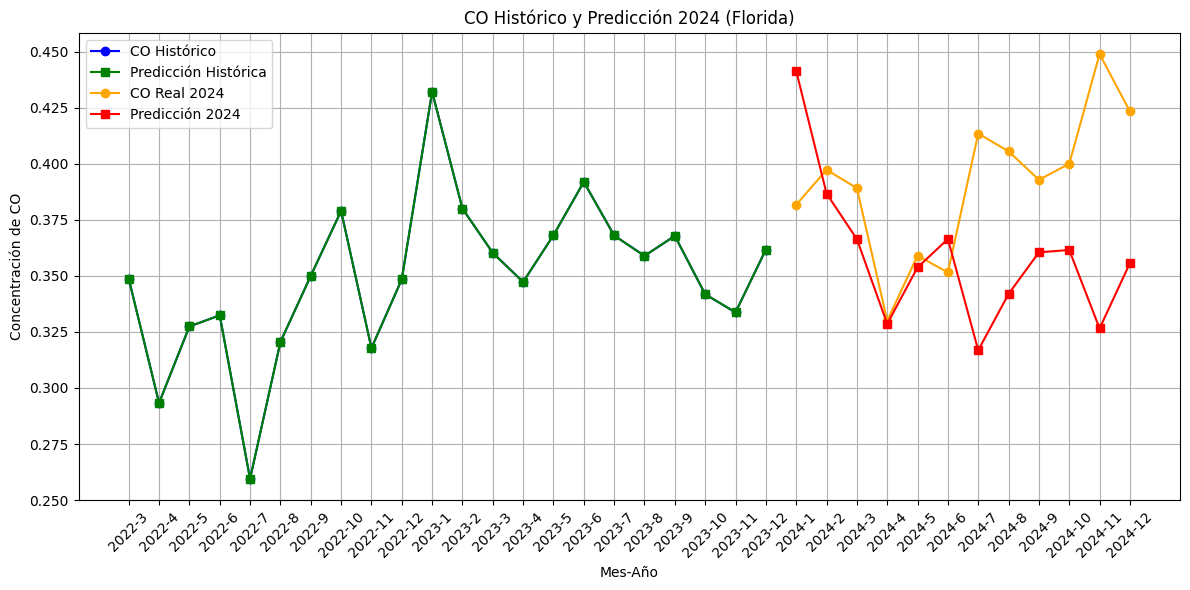

In [17]:
plt.figure(figsize=(12,6))

# CO histórico (2022-2023)
plt.plot(monthly_avg['Year'].astype(str) + '-' + monthly_avg['Month'].astype(str),
         monthly_avg['CO'], marker='o', label='CO Histórico', color='blue')

# Predicción histórica (sobre 2022-2023)
plt.plot(monthly_avg['Year'].astype(str) + '-' + monthly_avg['Month'].astype(str),
         monthly_avg['Pred_CO'], marker='s', label='Predicción Histórica', color='green')

# CO real 2024
plt.plot(comparison_2024['Year'].astype(str) + '-' + comparison_2024['Month'].astype(str),
         comparison_2024['CO_Real'], marker='o', label='CO Real 2024', color='orange')

# Predicción 2024
plt.plot(comparison_2024['Year'].astype(str) + '-' + comparison_2024['Month'].astype(str),
         comparison_2024['Pred_CO'], marker='s', label='Predicción 2024', color='red')

plt.xticks(rotation=45)
plt.xlabel('Mes-Año')
plt.ylabel('Concentración de CO')
plt.title('CO Histórico y Predicción 2024 (Florida)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()